Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# PU Learning with Different Mask Rate - Built-in Solution


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder
import lightgbm as lgb
from lightgbm import LGBMClassifier
from matplotlib import pylab as plt
from pulearn import ElkanotoPuClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
label_col = 'deposit'
masked_label = 'masked_deposit'

raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
print(raw_df.shape)
print(raw_df[label_col].value_counts())

cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
raw_df[cat_features] = raw_df[cat_features].astype('category')

raw_df.head()

(11162, 17)
0    5873
1    5289
Name: deposit, dtype: int64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [4]:
def mask_labels_1class_labeled(df, label_col, masked_label, partially_labeled_class=1, mask_rate=0.95):
    df['keep_label'] = False 
    all_pos_perct = raw_df[label_col].value_counts()[1]/raw_df[label_col].shape[0]
    exp_pos_perct = 1 - mask_rate
    if exp_pos_perct <= all_pos_perct:
        df.loc[df[df[label_col]==partially_labeled_class]\
          .sample(frac=exp_pos_perct/all_pos_perct, random_state=10).index, 'keep_label'] = True
    else:
        print(f'Total pos rate cannot be higher than {exp_pos_perct*100}%, all the masked data is negative now!')
        df.loc[df[df[label_col]==partially_labeled_class]\
          .sample(frac=1, random_state=10).index, 'keep_label'] = True
        
    df[masked_label] = df.apply(lambda r: r[label_col] if r['keep_label']==True else -1, axis=1)
    
    return df


def get_train_test_after_mask(raw_df, label_col, masked_label, partially_labeled_class=1, mask_rate=0.95):
    # mask the data
    masked_df = mask_labels_1class_labeled(raw_df, label_col, masked_label, partially_labeled_class, mask_rate)
    masked_df['has_label'] = masked_df['keep_label'].astype(int)

    all_y_df = masked_df[[label_col, 'keep_label', masked_label, 'has_label']]
    y = masked_df['has_label']
    X = masked_df.drop(all_y_df.columns, axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)
    all_y_train = all_y_df.iloc[y_train.index]
    all_y_test = all_y_df.iloc[y_test.index]

    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    all_y_train.reset_index(inplace=True, drop=True)
    all_y_test.reset_index(inplace=True, drop=True)
    
    encoder = TargetEncoder(cols=cat_features)
    encoded_X_train = encoder.fit_transform(X_train, y_train)
    encoded_X_test = encoder.transform(X_test)
    
    return encoded_X_train, encoded_X_test, y_train, y_test, all_y_train, all_y_test


def pu_eval(all_y_test, threshold=0.7):
    # predicted positive class percentage
    pred_pos_perct = all_y_test[all_y_test['pred_label']>= threshold].shape[0]/all_y_test.shape[0]

    # recall on known labels
    pos_label_df = all_y_test[all_y_test['masked_deposit']==1]
    tp = pos_label_df[pos_label_df['pred_label']>=threshold].shape[0]
    fn = pos_label_df[pos_label_df['pred_label']<threshold].shape[0]
    known_recall = tp/(tp + fn)
    
    return pred_pos_perct, known_recall


def plot_performance_per_threshold(threshold_performance_dct, color_dct, title, fig_size=[15, 7]):
    plt.figure(figsize=(fig_size[0], fig_size[1]))
    ax = plt.gca()
    ax.set_ylim([0, 1]) # set y-axis range
    
    x = threshold_performance_dct['threshold_lst']
    
    for performance_name, performance_lst in threshold_performance_dct.items():
        if (performance_name=='threshold_lst'):
            continue
        ax.plot(x, performance_lst, color=color_dct[performance_name], label=performance_name, marker='*')
        
        # annotate y_value along the line
        for i,j in zip(x, performance_lst):
            ax.annotate(str(j),xy=(i,j)) 
    
    plt.xlabel('Positive Label Threshold')
    plt.ylabel('Performance')
    plt.legend(loc='best')
    plt.title(title)
    display(plt)
    
    
def get_plot_dcts(threshold_lst, real_pos_perct):
    threshold_performance_dct = {
        'threshold_lst': threshold_lst,
        'real_pos_perct': [round(real_pos_perct, 2)]*len(threshold_lst),
        'pred_pos_perct': [],
        'known_recall': []
    }
    color_dct = {'real_pos_perct': 'r', 'pred_pos_perct': 'green', 'known_recall': 'purple'}

    for threshold in threshold_lst:
        pred_pos_perct, known_recall = pu_eval(all_y_test, threshold)
        threshold_performance_dct['pred_pos_perct'].append(round(pred_pos_perct, 2))
        threshold_performance_dct['known_recall'].append(round(known_recall, 2))
        
    return threshold_performance_dct, color_dct


def get_pu_performance(encoded_X_train, y_train, encoded_X_test, all_y_test, masked_label, label_col, mask_rate):
    params = {'num_leaves': 4, 'learning_rate': 0.01, 'bagging_fraction': 0.8506740422636537, 'feature_fraction': 0.6643670461510903, 
          'bagging_freq': 18, 'min_data_in_leaf': 1133, 'num_iterations': 2956, 'objective': 'binary', 'metric': 'auc', 'random_state': 10, 
          'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4, 'is_unbalance':True, 'max_bin':250}
    opt_model = LGBMClassifier(**params)
    
    pu_estimator = ElkanotoPuClassifier(estimator=opt_model, hold_out_ratio=0.2)
    pu_estimator.fit(encoded_X_train.to_numpy(), y_train.to_numpy())
    pos_label_prob = pu_estimator.predict_proba(encoded_X_test.to_numpy())
    
    real_pos_perct = all_y_test[all_y_test[label_col]==1].shape[0]/all_y_test.shape[0]  # business estimated percentage should align with this percentage 

    all_y_test['pred_label'] = pos_label_prob
    threshold_lst = np.arange(0.5, 1, 0.1)
    threshold_performance_dct, color_dct = get_plot_dcts(threshold_lst, real_pos_perct)
    plot_performance_per_threshold(threshold_performance_dct, color_dct, title=f'PU Learning Performance per Threshold (mask_rate={mask_rate})', fig_size=[15, 7])

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18


<module 'matplotlib.pylab' from 'C:\\Users\\wuhan\\anaconda3\\envs\\replendent_tree\\lib\\site-packages\\matplotlib\\pylab.py'>

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18


<module 'matplotlib.pylab' from 'C:\\Users\\wuhan\\anaconda3\\envs\\replendent_tree\\lib\\site-packages\\matplotlib\\pylab.py'>

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18


<module 'matplotlib.pylab' from 'C:\\Users\\wuhan\\anaconda3\\envs\\replendent_tree\\lib\\site-packages\\matplotlib\\pylab.py'>

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18


<module 'matplotlib.pylab' from 'C:\\Users\\wuhan\\anaconda3\\envs\\replendent_tree\\lib\\site-packages\\matplotlib\\pylab.py'>

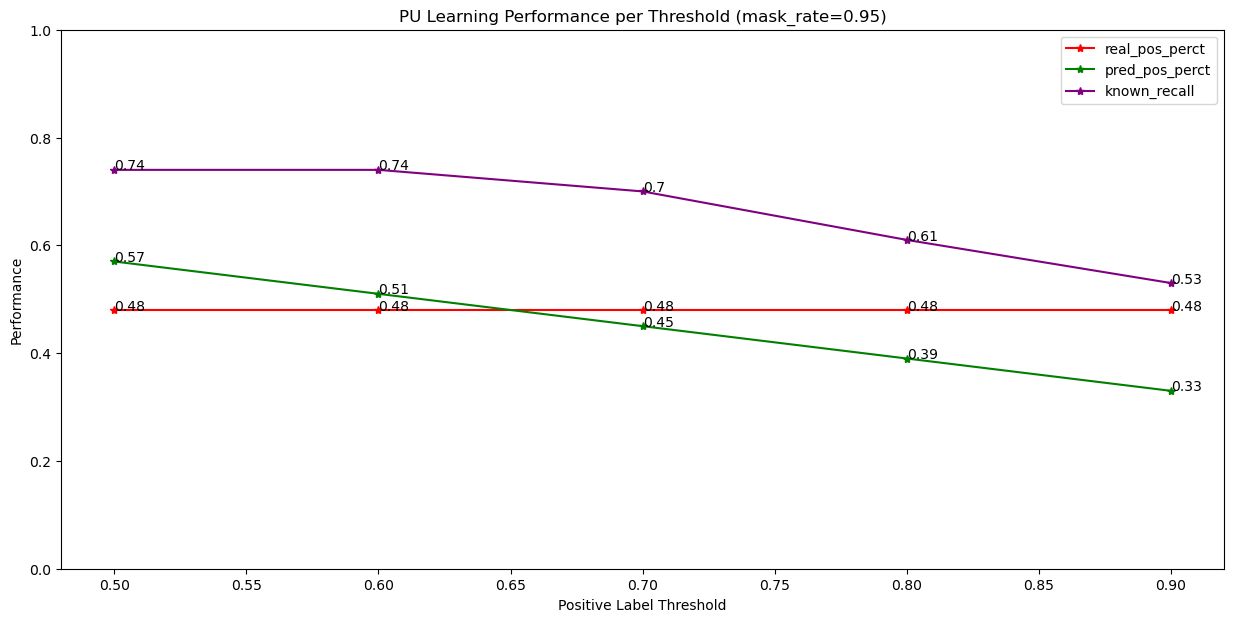

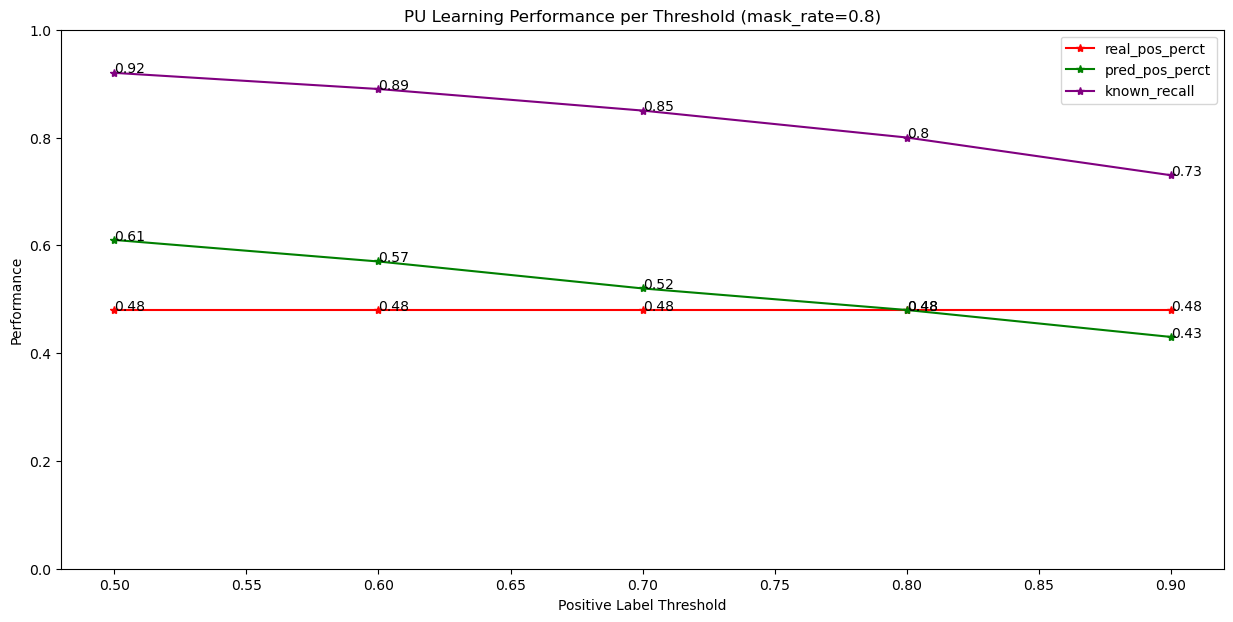

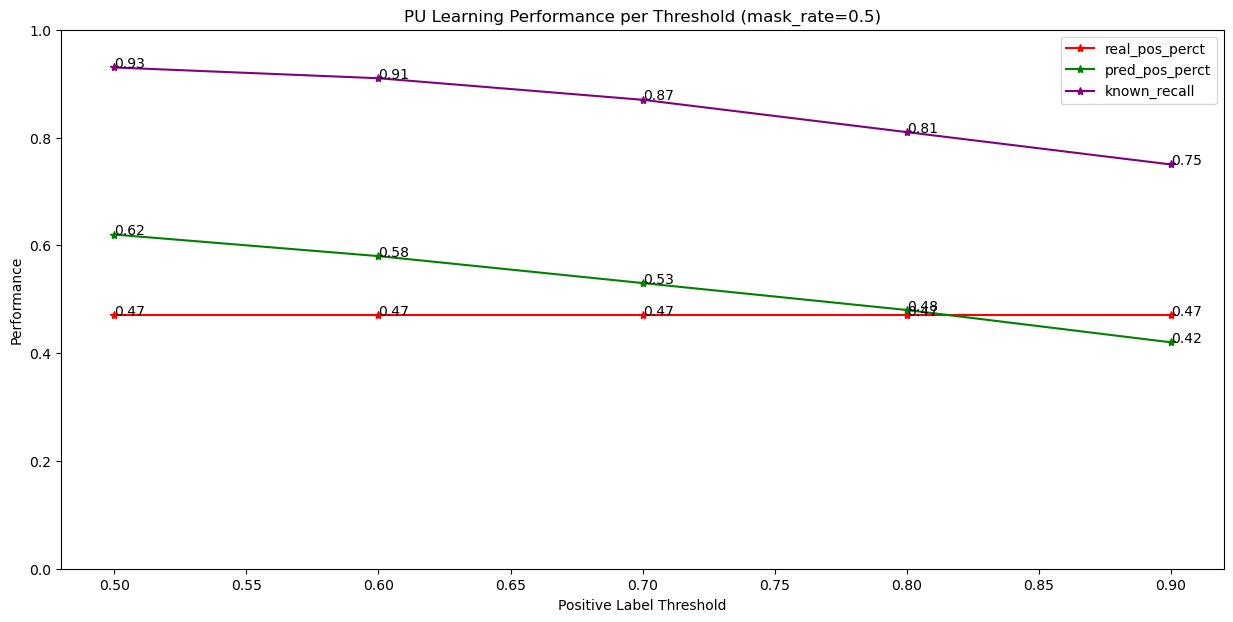

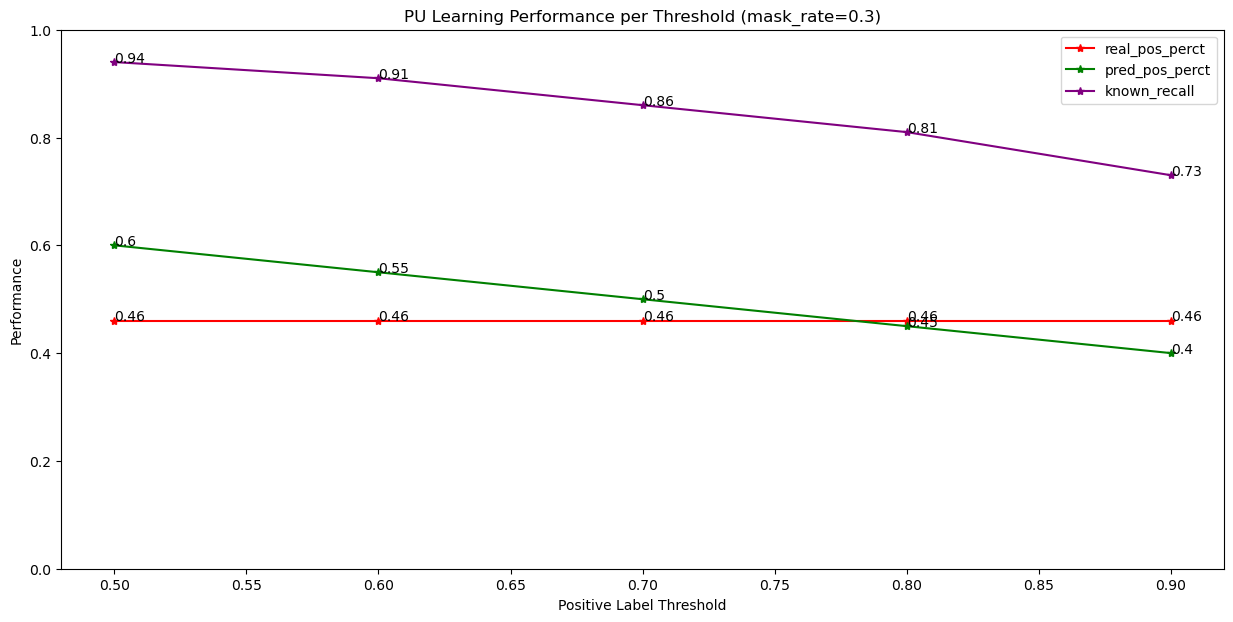

In [5]:
mask_rate_lst = [0.95, 0.8, 0.5, 0.3]

for mask_rate in mask_rate_lst:
    encoded_X_train, encoded_X_test, y_train, y_test, all_y_train, all_y_test = get_train_test_after_mask(raw_df, label_col, masked_label, partially_labeled_class=1, mask_rate=mask_rate)
    get_pu_performance(encoded_X_train, y_train, encoded_X_test, all_y_test, masked_label, label_col, mask_rate)